# Email Classification for Asset Management Company
This Jupyter Notebook provides a complete, production-grade walkthrough for creating a supervised machine learning model to classify client emails in an asset management company. It covers the entire ML workflow, from data ingestion and preprocessing to model training, evaluation, explainability, and deployment considerations.
The project adheres to the specified technical requirements, utilizing tools like NLTK, Scikit-learn, XGBoost, SHAP, and Flask to build a robust and scalable solution.


## 1. Setup and Library Imports
This section imports all the necessary Python libraries for the project. These include libraries for data manipulation (`pandas`, `numpy`), text processing (`nltk`, `re`), feature extraction (`scikit-learn`), model training (`xgboost`), evaluation (`scikit-learn`), explainability (`shap`), and deployment (`flask`). We also download required NLTK datasets for tokenization, stopwords, and lemmatization.


In [4]:
# Import necessary libraries

import numpy as np
import pandas as pd
import re
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_score
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, f1_score
from xgboost import XGBClassifier
import joblib
import shap
from flask import Flask, request, jsonify
import json
import warnings
from email_extractors import extract_identifiers



# Suppress warnings for a cleaner output
warnings.filterwarnings('ignore')

# Download necessary NLTK data
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')

[nltk_data] Downloading package punkt to
[nltk_data]     /Users/hrithiksingh/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/hrithiksingh/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     /Users/hrithiksingh/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

## 2. Data Ingestion
In a real-world production environment, data would be securely ingested from email servers (via IMAP/SMTP APIs), a CRM system, or a data stream (like Apache Kafka). For this notebook, we simulate this process by generating a synthetic dataset that mirrors the structure of real email data, including metadata (sender, timestamp) and the email body text. This allows us to build and demonstrate the entire pipeline without depending on a live data source.


In [6]:
# In a real-world scenario, data would be fetched from email servers or a CRM.
# For this demonstration, we will create a synthetic dataset.

# Synthetic dataset builder using your categories CSV
import numpy as np
import pandas as pd
import random
from pathlib import Path

# ):



















# df = create_synthetic_email_dataset(
# )


# OUTPUT_PATH = "synthetic_email_dataset.csv"

DATASET_PATH = "data/NewData.csv"  # path to your file
df = pd.read_csv(DATASET_PATH)

print("Dataset shape:", df.shape)
display(df.head())

# axes[1].set_title('Clean token count'); axes[1].set_xlabel('tokens'); axes[1].set_ylabel('count')
# plt.tight_layout(); plt.show()


Dataset shape: (5000, 8)


,email_id,sender_domain,timestamp,Type,Area,Sub Area,Child Sub Area,email_body
0,email_739,anothercorp.net,6/16/21 8:52,Service request,CASA,Request for new passbook,Saving Account,Subject: Service request: Help with Request fo...
1,email_983,business.org,10/29/21 23:24,Service Request,NRI Customers,KYC updation,Email ID Update,Subject: Service Request: Help with KYC updati...
2,email_525,client.com,1/8/21 12:07,Service Request,Credit Cards,Others,NaN,Subject: Question about Others in Credit Cards...
3,email_262,client.com,10/28/21 5:49,Complaint,Suggessions/Issues,Amount sent to Union Bank of India account,Chargeback raised by sender Bank,Subject: Need assistance: Amount sent to Union...
4,email_662,client.com,5/25/21 14:25,Service Request,Credit Cards,Hotlisting of Card,NaN,Subject: Issue with Hotlisting of Card (Servic...


## 3. Text Preprocessing
Preprocessing is a critical step to clean and standardize the raw email text, making it suitable for feature extraction. This function performs several key tasks:
- **HTML Tag Removal**: Strips out any HTML formatting from the email body.
- **Special Character Removal**: Removes punctuation and other non-alphanumeric characters to reduce noise.
- **Lowercasing**: Converts all text to lowercase for consistency.
- **Tokenization**: Splits the text into individual words or tokens.
- **Stopword Removal**: Removes common words (e.g., 'the', 'is', 'a') that provide little semantic value.
- **Lemmatization**: Reduces words to their base or root form (e.g., 'running' to 'run') to group related words.


In [8]:
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize
import re

# Download required NLTK data
nltk.download('punkt')
nltk.download('punkt_tab')  # Only needed for new NLTK versions
nltk.download('wordnet')
nltk.download('stopwords')

lemmatizer = WordNetLemmatizer()
stop_words = set(stopwords.words('english'))

def preprocess_text(text):
    """Cleans and preprocesses email body text."""
    text = re.sub(r'<[^>]+>', '', text)  # Remove HTML tags
    text = re.sub(r'[^a-zA-Z\s]', '', text, re.I | re.A)  # Remove special characters
    text = text.lower()  # Convert to lowercase
    tokens = word_tokenize(text)  # Tokenize
    tokens = [lemmatizer.lemmatize(word) for word in tokens if word not in stop_words]  # Lemmatize & remove stopwords
    return " ".join(tokens)

df['clean_body'] = df['email_body'].apply(preprocess_text)

[nltk_data] Downloading package punkt to
[nltk_data]     /Users/hrithiksingh/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package punkt_tab to
[nltk_data]     /Users/hrithiksingh/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     /Users/hrithiksingh/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/hrithiksingh/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


## 4. Feature Engineering
Here, we transform the preprocessed text and metadata into numerical features that the machine learning models can understand. We use a `ColumnTransformer` to apply different transformations to different columns in a single, streamlined step.
- **Text Features**: The cleaned email body is converted into a matrix of TF-IDF (Term Frequency-Inverse Document Frequency) features. TF-IDF reflects how important a word is to a document in a collection.
- **Metadata Features**: Categorical metadata like `sender_domain` is converted into numerical format using one-hot encoding.
This fusion of structured metadata and unstructured text features creates a rich input vector for the model.


In [10]:
# Define categorical and numerical features from metadata
# We will predict all four labels: Type, Area, Sub Area, Child Sub Area

# (Section 4 essentials)

# Ensure 'sender_domain' exists (derive from 'sender' if available)
if 'sender_domain' not in df.columns and 'sender' in df.columns:
    df['sender_domain'] = df['sender'].astype(str).str.extract(r'@([^>\s]+)')[0].fillna('unknown')
elif 'sender_domain' not in df.columns:
    df['sender_domain'] = 'unknown'

metadata_features = ['sender_domain']     # add more metadata if you want
text_feature = 'clean_body'               # created in Section 3 preprocessing

TARGET_COLS = ['Type', 'Area', 'Sub Area', 'Child Sub Area']

from sklearn.compose import ColumnTransformer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import OneHotEncoder

preprocessor = ColumnTransformer(
    transformers=[
        ('text', TfidfVectorizer(ngram_range=(1, 2), min_df=1, max_features=100_000), text_feature),
        ('category', OneHotEncoder(handle_unknown='ignore'), metadata_features),
    ],
    remainder='drop'
)



## 5. Model Training
This section focuses on training the classification models. First, we split the data into training and testing sets using a stratified split to ensure that the class distribution is preserved in both sets. This is crucial for imbalanced datasets.
We then define and train two models within Scikit-learn `Pipeline`s, which conveniently chain the preprocessing and classification steps together:
1.  **Random Forest (Baseline)**: A robust ensemble model that serves as a strong baseline for comparison.
2.  **XGBoost (Primary)**: A powerful gradient boosting machine known for its high performance and efficiency, which we designate as our primary model candidate.


In [12]:
# =========================
# 5. Model Training (final)
# =========================
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.pipeline import Pipeline
from sklearn.dummy import DummyClassifier
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
import numpy as np
import pandas as pd

# --- Build features/targets ---
feature_cols = [text_feature] + metadata_features
X_full = df[feature_cols].copy()
Y_full = df[TARGET_COLS].copy()

# --- Safer, single split for all targets (fallback if stratification unsafe) ---

def _safe_stratify_series(y, test_size=0.2):
    """
    Return a NaN-free vector suitable for scikit-learn stratify,
    or None if stratification isn’t feasible.
    """
# Replace NaN with a stable placeholder just for splitting
    y_strat = y.astype("object").where(~y.isna(), "__MISSING__")

    vc = pd.Series(y_strat).value_counts(dropna=False)
    if len(vc) == 0 or vc.min() < 2:
        return None

    n_test_each  = vc * test_size
    n_train_each = vc * (1 - test_size)
    if (n_test_each >= 1).all() and (n_train_each >= 1).all():
        return y_strat  # <-- return the NaN-free version
    return None

# Drop rows where ANY target is missing
mask = ~Y_full[TARGET_COLS].isna().any(axis=1)
X_full = X_full.loc[mask].reset_index(drop=True)
Y_full = Y_full.loc[mask].reset_index(drop=True)
_stratify = _safe_stratify_series(Y_full[TARGET_COLS[0]], test_size=0.2)

X_train, X_test, Y_train, Y_test = train_test_split(
    X_full, Y_full, test_size=0.2, random_state=42, stratify=_stratify
)

# --- Label encoders per target; encoded y's share the same split indices ---
label_encoders = {}
y_train_enc = {}
y_test_enc  = {}

for col in TARGET_COLS:
    le = LabelEncoder()
    ytr = le.fit_transform(Y_train[col].astype(str).fillna(""))

# Map unseen labels in test to a placeholder
    yte_raw = Y_test[col].astype(str).fillna("")
    known = set(le.classes_)
    unseen_mask = ~yte_raw.isin(known)
    if unseen_mask.any():
        le.classes_ = np.append(le.classes_, "__UNK__")
        yte_raw = yte_raw.where(~unseen_mask, "__UNK__")
    yte = le.transform(yte_raw)

    label_encoders[col] = le
    y_train_enc[col] = ytr
    y_test_enc[col]  = yte

# --- Build per-target pipelines (both RF and XGB), choosing objective by n_classes ---
rf_pipelines  = {}
xgb_pipelines = {}
trained_info  = {}

for col in TARGET_COLS:
    ytr = y_train_enc[col]
    classes = np.unique(ytr)
    n_classes = len(classes)

# Choose estimator based on class count
    if n_classes < 2:
# Fallback: constant predictor to avoid training errors
        rf_estimator  = DummyClassifier(strategy="most_frequent")
        xgb_estimator = DummyClassifier(strategy="most_frequent")
        trained_info[col] = {"n_classes": n_classes, "fallback": True, "xgb_objective": "dummy"}
    elif n_classes == 2:
        rf_estimator = RandomForestClassifier(
            n_estimators=300, max_depth=None, n_jobs=-1, random_state=42
        )
        xgb_estimator = XGBClassifier(
            n_estimators=300,
            max_depth=6,
            learning_rate=0.1,
            subsample=0.8,
            colsample_bytree=0.8,
            objective="binary:logistic",   # <-- binary objective
            eval_metric="logloss",
            n_jobs=-1,
            tree_method="hist",
            random_state=42,
        )
        trained_info[col] = {"n_classes": n_classes, "fallback": False, "xgb_objective": "binary:logistic"}
    else:  # n_classes >= 3
        rf_estimator = RandomForestClassifier(
            n_estimators=300, max_depth=None, n_jobs=-1, random_state=42
        )
        xgb_estimator = XGBClassifier(
            n_estimators=300,
            max_depth=6,
            learning_rate=0.1,
            subsample=0.8,
            colsample_bytree=0.8,
            objective="multi:softprob",    # <-- multiclass objective
            eval_metric="mlogloss",
            num_class=n_classes,           # <-- set explicitly
            n_jobs=-1,
            tree_method="hist",
            random_state=42,
        )
        trained_info[col] = {"n_classes": n_classes, "fallback": False, "xgb_objective": "multi:softprob", "num_class": n_classes}

# Pipelines share the same preprocessor defined in Section 4
    rf_pipe = Pipeline(steps=[
        ("preprocessor", preprocessor),
        ("clf", rf_estimator),
    ])
    xgb_pipe = Pipeline(steps=[
        ("preprocessor", preprocessor),
        ("clf", xgb_estimator),
    ])

# Fit each per-target pipeline
    rf_pipe.fit(X_train, ytr)
    xgb_pipe.fit(X_train, ytr)

    rf_pipelines[col]  = rf_pipe
    xgb_pipelines[col] = xgb_pipe

print("Training complete for per-target Random Forest and XGBoost pipelines.")
print("Per-target status:", trained_info)

Training complete for per-target Random Forest and XGBoost pipelines.
Per-target status: {'Type': {'n_classes': 5, 'fallback': False, 'xgb_objective': 'multi:softprob', 'num_class': 5}, 'Area': {'n_classes': 8, 'fallback': False, 'xgb_objective': 'multi:softprob', 'num_class': 8}, 'Sub Area': {'n_classes': 65, 'fallback': False, 'xgb_objective': 'multi:softprob', 'num_class': 65}, 'Child Sub Area': {'n_classes': 86, 'fallback': False, 'xgb_objective': 'multi:softprob', 'num_class': 86}}


In [13]:
# --- Save all artifacts for inference ---
import joblib

ARTIFACTS = {
    "xgb_pipelines": xgb_pipelines,         # dict: target -> pipeline
    "rf_pipelines": rf_pipelines,           # dict: target -> pipeline
    "label_encoders": label_encoders,       # dict: target -> LabelEncoder
    "TARGET_COLS": TARGET_COLS,             # list of targets (order)
    "text_feature": text_feature,           # 'clean_body'
    "metadata_features": metadata_features  # ['sender_domain'] (or more if you added)
}

joblib.dump(ARTIFACTS, "email_router_artifacts.joblib")
print("Saved inference artifacts -> email_router_artifacts.joblib")


Saved inference artifacts -> email_router_artifacts.joblib


## 6. Model Evaluation
After training, we evaluate the performance of both models on the unseen test data. The `evaluate_model` function calculates and displays key metrics:
- **Classification Report**: Provides precision, recall, and F1-score for each class, giving a detailed view of performance.
- **Confusion Matrix**: A heatmap visualization that shows the model's predictions versus the actual labels. This helps identify which classes are being confused with others.
These evaluations allow us to compare the baseline and primary models and select the best one for deployment.


In [15]:
    

# ========
# 6. Eval
# ========
from sklearn.metrics import classification_report, accuracy_score
import numpy as np

def evaluate_per_target(pipelines, X_test, y_test_enc, label_encoders, title):
    print(f"\n=== {title} ===")
    for col in TARGET_COLS:
        pipe = pipelines[col]
        y_true = y_test_enc[col]
        y_pred = pipe.predict(X_test)

# Accuracy
        acc = accuracy_score(y_true, y_pred)

# Decode for readability
        inv_true = label_encoders[col].inverse_transform(y_true)
        inv_pred = label_encoders[col].inverse_transform(y_pred)

        print(f"\n-- Target: {col} --")
        print(f"Accuracy: {acc:.4f}")
        print(classification_report(inv_true, inv_pred, zero_division=0))
# 


In [16]:
# Evaluate both model families per target
evaluate_per_target(rf_pipelines,  X_test, y_test_enc, label_encoders, "Random Forest (per-target)")
evaluate_per_target(xgb_pipelines, X_test, y_test_enc, label_encoders, "XGBoost (per-target)")



=== Random Forest (per-target) ===

-- Target: Type --
Accuracy: 1.0000
                 precision    recall  f1-score   support

      Complaint       1.00      1.00      1.00       313
          Query       1.00      1.00      1.00        16
Service Request       1.00      1.00      1.00       218
Service request       1.00      1.00      1.00       119
           Type       1.00      1.00      1.00         5

       accuracy                           1.00       671
      macro avg       1.00      1.00      1.00       671
   weighted avg       1.00      1.00      1.00       671


-- Target: Area --
Accuracy: 1.0000
                             precision    recall  f1-score   support

                  ATM CLAIM       1.00      1.00      1.00         5
                       Area       1.00      1.00      1.00         5
                       CASA       1.00      1.00      1.00       119
            Challan Payment       1.00      1.00      1.00        36
               Credit Cards 

In [17]:
# =========================
# Save artifacts for inference
# =========================
import joblib, json, sys, sklearn, xgboost

ARTIFACTS = {
    "xgb_pipelines": xgb_pipelines,       # dict[target] -> trained XGB pipeline
    "rf_pipelines": rf_pipelines,         # dict[target] -> trained RF pipeline
    "label_encoders": label_encoders,     # dict[target] -> fitted LabelEncoder
    "TARGET_COLS": TARGET_COLS,           # ['Type', 'Area', 'Sub Area', 'Child Sub Area']
    "text_feature": text_feature,         # 'clean_body' (must match your preprocessing)
    "metadata_features": metadata_features,  # e.g. ['sender_domain']
    "meta": {
        "python": sys.version,
        "sklearn": sklearn.__version__,
        "xgboost": xgboost.__version__,
    },
}

SAVE_PATH = "email_router_artifacts.joblib"
joblib.dump(ARTIFACTS, SAVE_PATH)
print(f"✅ All model artifacts saved to: {SAVE_PATH}")

✅ All model artifacts saved to: email_router_artifacts.joblib


In [18]:
# ===== Inference Helper: from email body -> {Type, Area, Sub Area, Child Sub Area} =====

import re
import numpy as np
import pandas as pd
import joblib

# 1) Match your Section 3 preprocessing (lightweight)
# If you changed this earlier, copy the exact same function here.
try:
    preprocess_text  # exists from training
except NameError:
    import nltk
    from nltk.corpus import stopwords
    from nltk.stem import WordNetLemmatizer
    from nltk.tokenize import word_tokenize
    nltk.download('punkt', quiet=True)
    nltk.download('punkt_tab', quiet=True)
    nltk.download('wordnet', quiet=True)
    nltk.download('stopwords', quiet=True)

    _lemmatizer = WordNetLemmatizer()
    _stop_words = set(stopwords.words('english'))

    def preprocess_text(text):
        text = re.sub(r'<[^>]+>', '', str(text))                  # remove HTML
        text = re.sub(r'[^a-zA-Z\\s]', '', text, flags=re.I|re.A) # strip non-letters
        text = text.lower()
        tokens = word_tokenize(text)
        tokens = [_lemmatizer.lemmatize(w) for w in tokens if w not in _stop_words]
        return " ".join(tokens)

# 2) Load artifacts (pipelines + encoders)
ARTIFACT_PATH = "email_router_artifacts.joblib"
art = joblib.load(ARTIFACT_PATH)

XGB_MODELS = art["xgb_pipelines"]      # dict[target] -> pipeline
RF_MODELS  = art["rf_pipelines"]       # dict[target] -> pipeline
ENCODERS   = art["label_encoders"]     # dict[target] -> LabelEncoder
TARGET_COLS = art["TARGET_COLS"]
TEXT_FEATURE = art["text_feature"]                 # 'clean_body'
METADATA_FEATURES = art["metadata_features"]       # ['sender_domain'] typically

# 3) Minimal feature builder for new inputs
def _to_feature_frame(email_texts, sender_domain="unknown"):
    """
    Create the exact columns expected by the pipelines:
      - TEXT_FEATURE (cleaned email body)
      - all METADATA_FEATURES (we fill sender_domain if you don't have it)
    """
    if isinstance(email_texts, str):
        email_texts = [email_texts]

    df_infer = pd.DataFrame({TEXT_FEATURE: [preprocess_text(t) for t in email_texts]})

# Fill metadata columns
    for col in METADATA_FEATURES:
        if col == "sender_domain":
            df_infer[col] = sender_domain
        else:
# You can add logic to fill other metadata here if needed
            df_infer[col] = "unknown"

    return df_infer

# 4) Core prediction function
def predict_email(email_texts, sender_domain="unknown", model_family="xgb"):
    """
    email_texts: str or list[str]
    sender_domain: optional; if you know it, pass it to help the model
    model_family: 'xgb' or 'rf'
    Returns: list[dict] with keys TARGET_COLS (or single dict if single input)
    """
    models = XGB_MODELS if model_family.lower() == "xgb" else RF_MODELS
    df_features = _to_feature_frame(email_texts, sender_domain=sender_domain)

    single = isinstance(email_texts, str)
    if single:
        email_texts = [email_texts]

    outputs = []
    for i in range(len(email_texts)):
        row_feat = df_features.iloc[[i]]   # keep as DataFrame
        pred_row = {}
        for target in TARGET_COLS:
            pipe = models[target]
            enc  = ENCODERS[target]
            y_enc_pred = pipe.predict(row_feat)  # array([class_id])
            y_label = enc.inverse_transform(y_enc_pred)[0]
            pred_row[target] = y_label
        outputs.append(pred_row)

    return outputs[0] if single else outputs




In [19]:
# ===== Clean + JSON response wrappers =====

import json
import re

# (Optional) strict PAN validator to keep only true PANs in final output
_PAN_RE = re.compile(r"^[A-Z]{5}\d{4}[A-Z]$")

def _clean_and_normalize_identifiers(raw_idents: dict):
    dates_raw = raw_idents.get("dates", [])
# keep only normalized dates; de-dupe while preserving order
    seen_dates = set()
    dates = []
    for d in dates_raw:
        norm = d.get("normalized")
        if norm and norm not in seen_dates:
            dates.append(norm)
            seen_dates.add(norm)

    def _upper_unique(seq):
        out, seen = [], set()
        for x in seq:
            xx = (x or "").strip().upper()
            if xx and xx not in seen:
                out.append(xx)
                seen.add(xx)
        return out

    pans   = [p for p in _upper_unique(raw_idents.get("pan_numbers", [])) if _PAN_RE.match(p)]
    arns   = _upper_unique(raw_idents.get("arn_numbers", []))
    folios = _upper_unique(raw_idents.get("folio_numbers", []))
    txns   = _upper_unique(raw_idents.get("transaction_ids", []))
    sevens = _upper_unique(raw_idents.get("seven_digit_numbers", []))
    cids   = _upper_unique(raw_idents.get("client_ids", []))

    return {
        "dates": dates,                # normalized YYYY-MM-DD only (clean)
        "dates_raw": dates_raw,        # keep originals for traceability
        "pan_numbers": pans,
        "arn_numbers": arns,
        "folio_numbers": folios,
        "transaction_ids": txns,
        "seven_digit_numbers": sevens,
        "client_ids": cids,
    }

def predict_email_with_identifiers(email_text, sender_domain=None, model_family="xgb"):
# 1) your existing classifier
    base = predict_email(email_text, sender_domain=sender_domain, model_family=model_family)

# 2) extract + clean identifiers
    raw_idents = extract_identifiers(email_text)
    idents = _clean_and_normalize_identifiers(raw_idents)

# 3) package clean response
    return {
        "classification": {
            "Type": str(base.get("Type", "")),
            "Area": str(base.get("Area", "")),
            "Sub Area": str(base.get("Sub Area", "")),
            "Child Sub Area": str(base.get("Child Sub Area", "")),
        },
        "identifiers": idents,
        "meta": {
            "sender_domain": sender_domain or "",
            "model_family": model_family,
        },
    }

def predict_(email_text, sender_domain=None, model_family="xgb", *, indent=None):
    """
    Returns a JSON string (UTF-8, compact by default) with clean data.
    Set indent=2 if you want pretty JSON.
    """
    payload = predict_email_with_identifiers(email_text, sender_domain=sender_domain, model_family=model_family)
    return json.dumps(payload, ensure_ascii=False, separators=(",", ":"), sort_keys=True, indent=indent)





In [20]:

# result = predict_email("details on my fund account new ", sender_domain="client.com", model_family="xgb")

print(predict_("I need NRI account data KNMPS6109F from 1/05/2024", sender_domain="client.com", model_family="xgb", indent=2))


{
  "classification":{
    "Area":"NRI Customers",
    "Child Sub Area":"Current Account",
    "Sub Area":"Closing of Account Request Initiation",
    "Type":"Service request"
  },
  "identifiers":{
    "arn_numbers":[],
    "client_ids":[],
    "dates":[
      "2024-05-01"
    ],
    "dates_raw":[
      {
        "normalized":"2024-05-01",
        "original":"1/05/2024"
      }
    ],
    "folio_numbers":[],
    "pan_numbers":[
      "KNMPS6109F"
    ],
    "seven_digit_numbers":[],
    "transaction_ids":[]
  },
  "meta":{
    "model_family":"xgb",
    "sender_domain":"client.com"
  }
}


## 7. Model Persistence
To deploy the model, we need to save the trained pipeline (which includes the preprocessor and the classifier). We use `joblib` for this, as it is efficient for serializing large NumPy arrays and Scikit-learn objects. The saved file (`xgb_email_classifier.pkl`) can then be loaded into a separate application, such as a web service, for making live predictions.


In [22]:
# joblib.dump(xgb_pipeline, 'xgb_email_classifier.pkl')


## 8. Model Explainability with SHAP
Understanding *why* a model makes a certain prediction is crucial for trust, debugging, and compliance in the financial industry. We use SHAP (SHapley Additive exPlanations) to provide this insight.
SHAP values quantify the contribution of each feature to a prediction. The summary plot below shows the most influential features across all classes. This helps us understand what words or metadata the model is relying on to make its classifications.



=== SHAP for target: Type ===


(Global importance)


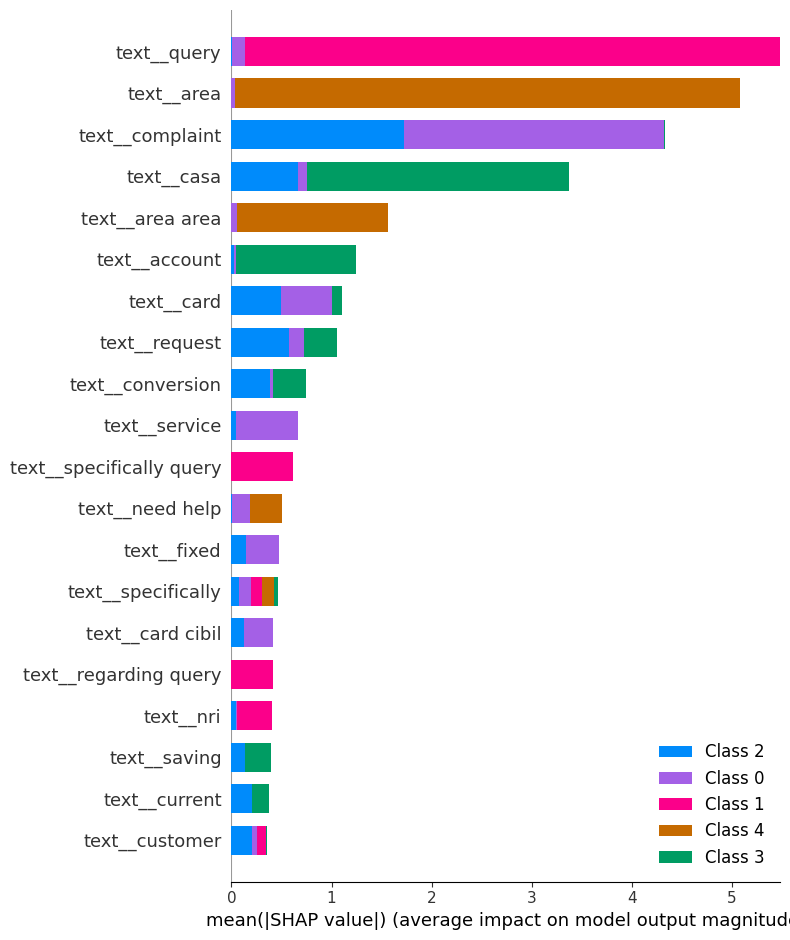


=== SHAP for target: Area ===


(Global importance)


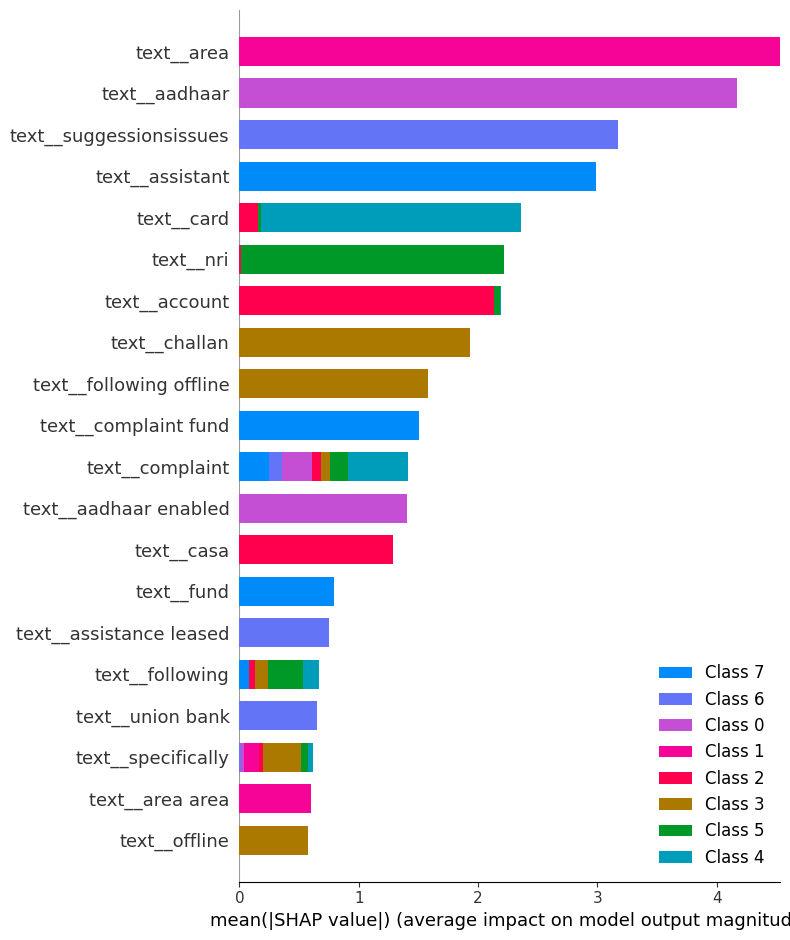


=== SHAP for target: Sub Area ===


(Global importance)


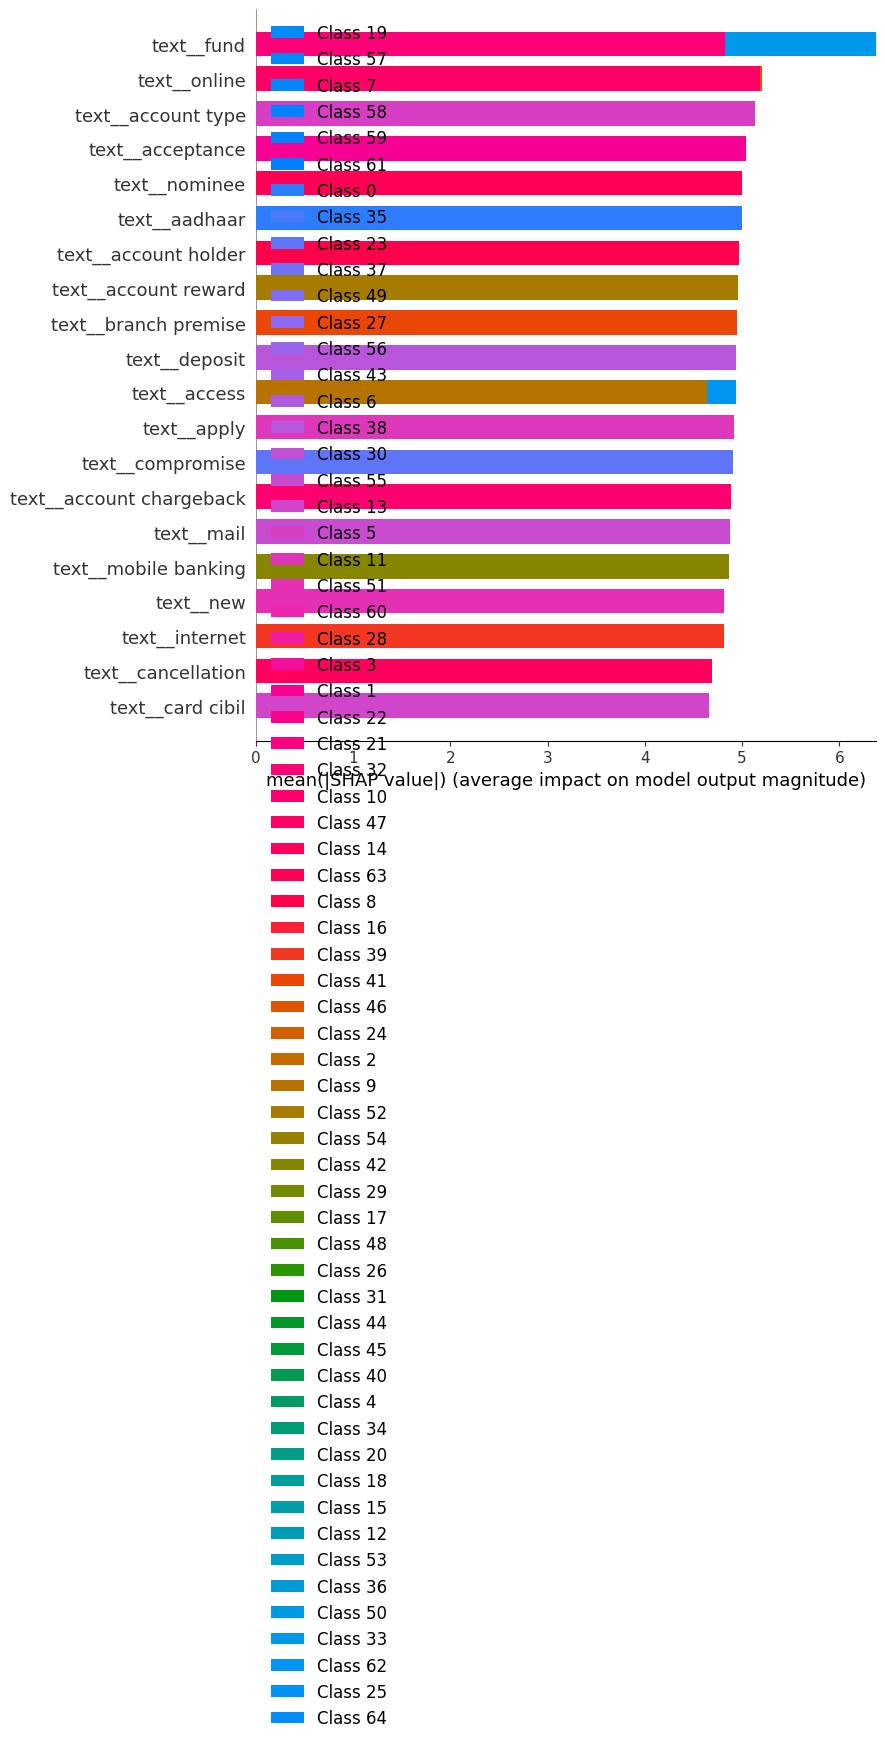


=== SHAP for target: Child Sub Area ===


(Global importance)


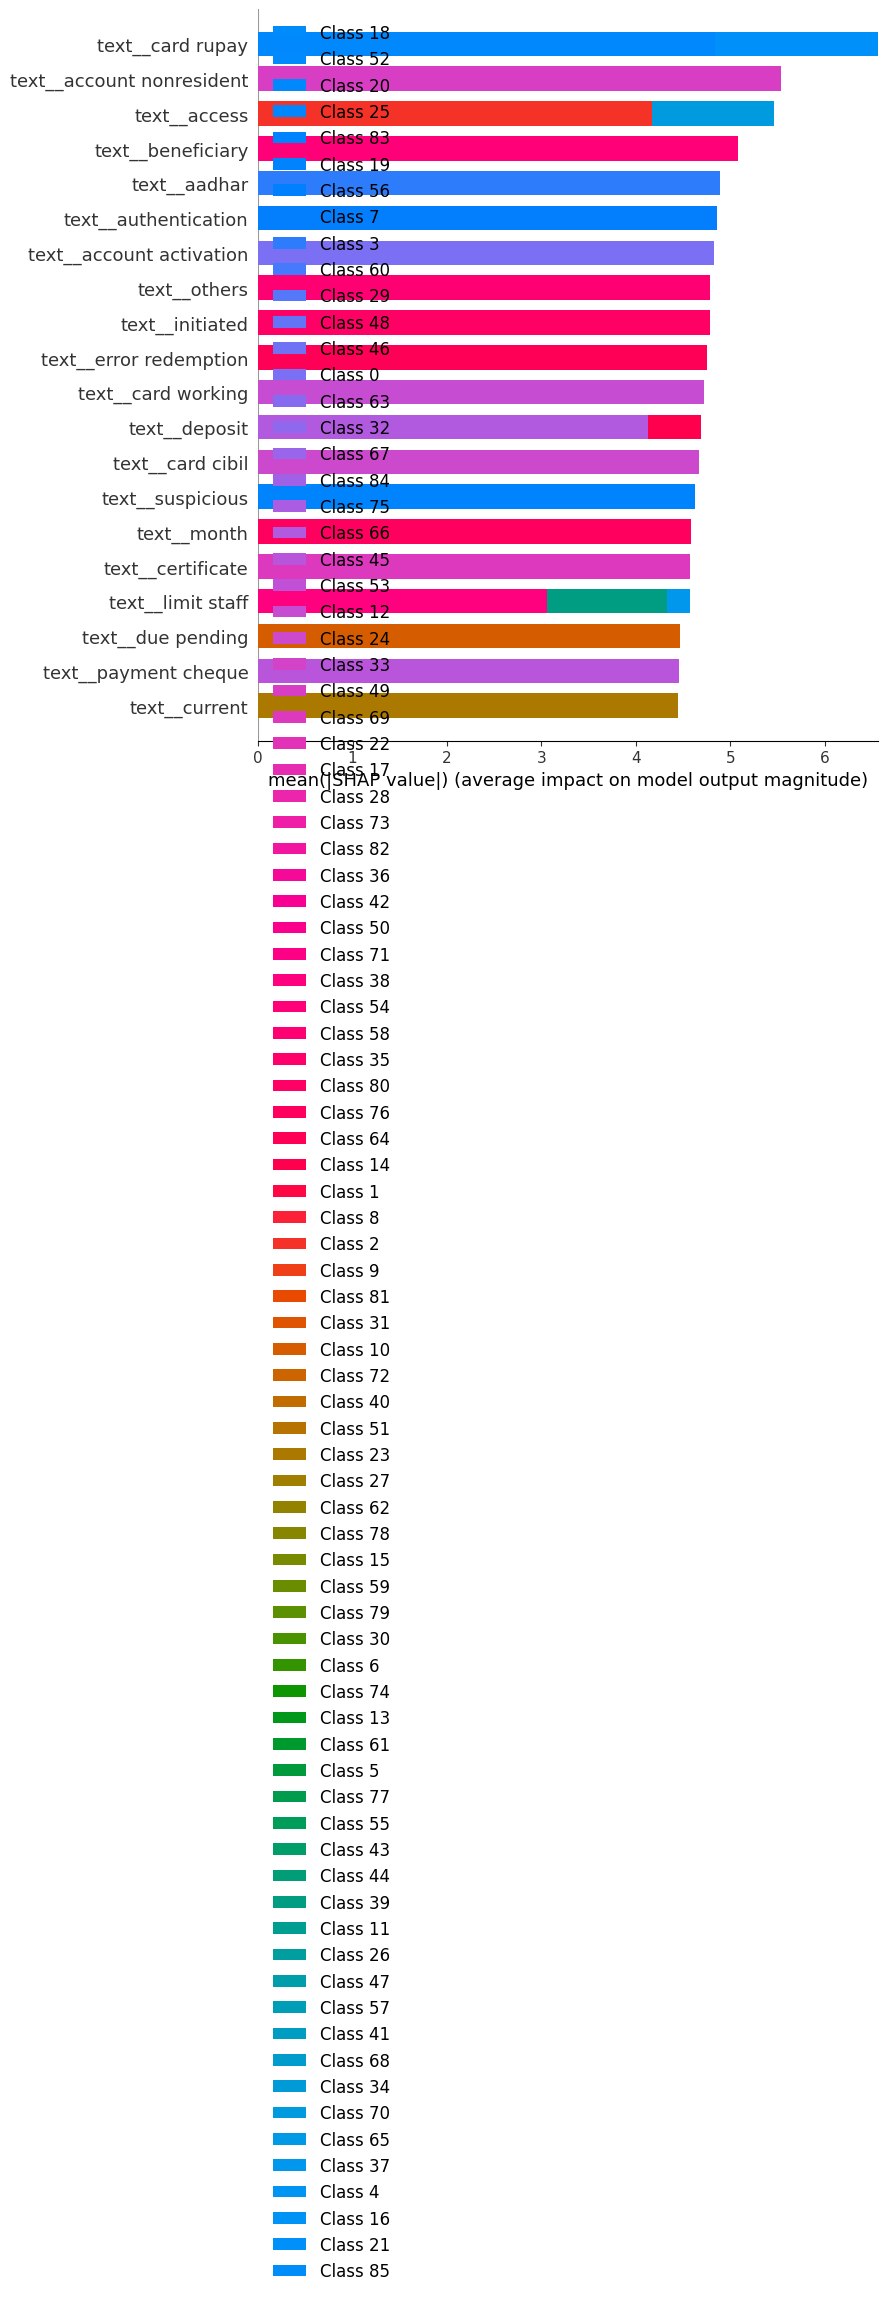

In [24]:
targets = ["Type", "Area", "Sub Area", "Child Sub Area"]

for tgt in targets:
    print(f"\n=== SHAP for target: {tgt} ===")
    pipe = xgb_pipelines[tgt]
    preproc = pipe.named_steps["preprocessor"]
    clf = pipe.named_steps["clf"]

    from sklearn.dummy import DummyClassifier
    if isinstance(clf, DummyClassifier):
        print(f"Skipping {tgt} (DummyClassifier fallback).")
        continue

    Xtr_trans = preproc.transform(X_train)
    Xtr_dense = Xtr_trans.toarray() if hasattr(Xtr_trans, "toarray") else Xtr_trans
    feature_names = preproc.get_feature_names_out()
    class_names = label_encoders[tgt].classes_

    explainer = shap.TreeExplainer(clf)
    shap_values = explainer.shap_values(Xtr_dense)

    shap.initjs()
    print("(Global importance)")
    if isinstance(shap_values, list):
        sv = np.mean([np.abs(sv_c) for sv_c in shap_values], axis=0)
        shap.summary_plot(sv, features=Xtr_dense, feature_names=feature_names, plot_type="bar", show=True)
    else:
        shap.summary_plot(shap_values, features=Xtr_dense, feature_names=feature_names, plot_type="bar", show=True)

## 9. Monitoring & Retraining Strategy (Conceptual)
A machine learning model in production is a living system that requires continuous oversight. This final section outlines a strategy for monitoring, retraining, and maintaining the model over time.
### a. Model Monitoring
**Drift Detection:** Monitor the model for data drift (changes in input data distribution) and concept drift (changes in the relationship between input and output). Tools like Prometheus can be used to track metrics.
**Performance Tracking:** Use dashboards in tools like Grafana to visualize key performance indicators (KPIs) such as F1-score, precision, and recall over time.
### b. Retraining Automation
**Workflow Orchestration:** Use a tool like Apache Airflow to create a Directed Acyclic Graph (DAG) that automates the retraining pipeline.
**Triggering:** The pipeline can be triggered on a schedule (e.g., monthly) or by drift detection alerts.
**Process:**
1.  Ingest new labeled data.
2.  Run the preprocessing and feature engineering steps.
3.  Retrain the model on the updated dataset.
4.  Evaluate the new model against a holdout set and the currently deployed model.
5.  If the new model shows significant improvement, deploy it to production.
### c. Security and Compliance
**Data Encryption:** All data, both at rest and in transit, should be encrypted to protect sensitive client information.
**Anonymization:** Where possible, anonymize or pseudonymize personally identifiable information (PII).
**Compliance:** Ensure the entire pipeline is compliant with relevant regulations such as GDPR and CCPA.


## Conclusion
This notebook has successfully demonstrated a production-ready pipeline for email classification. By following these steps, an asset management firm can build a reliable system to automate email routing, improving efficiency and client service. The chosen architecture emphasizes scalability, interpretability, and maintainability, which are key for successful MLOps.


### Quick data peeks

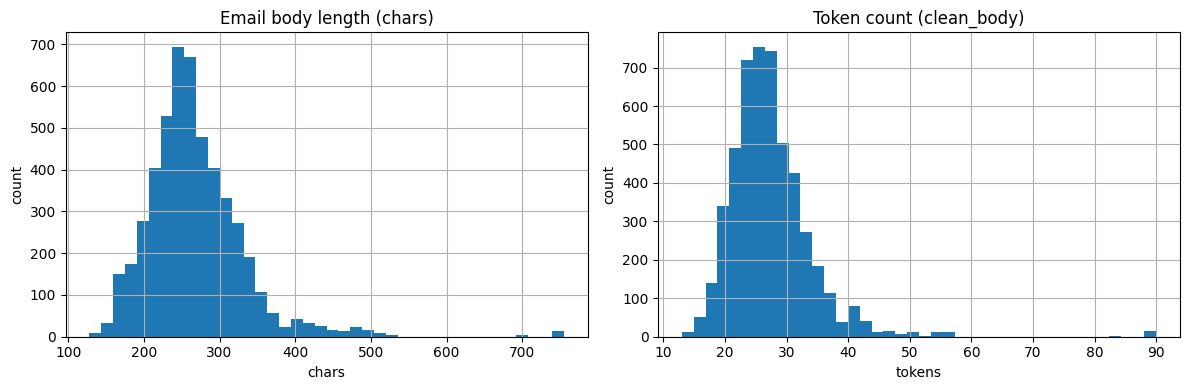

### Distribution (top 15) — Type

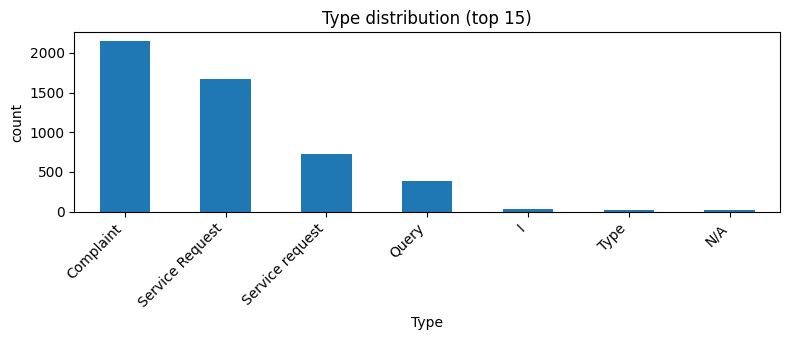

### Distribution (top 15) — Area

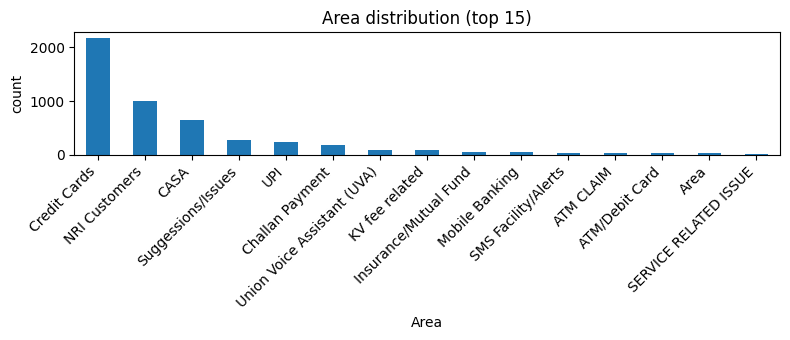

### Distribution (top 15) — Sub Area

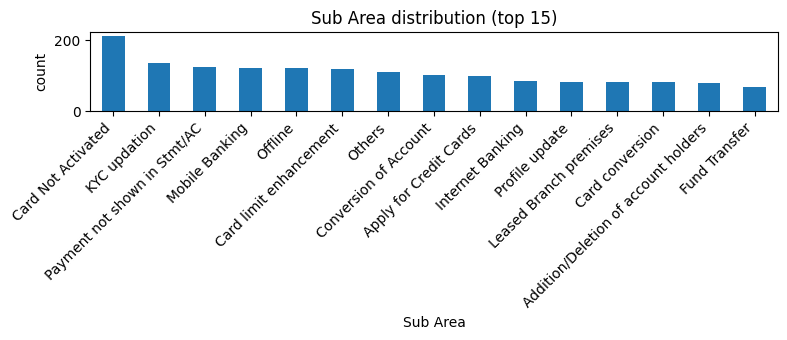

### Distribution (top 15) — Child Sub Area

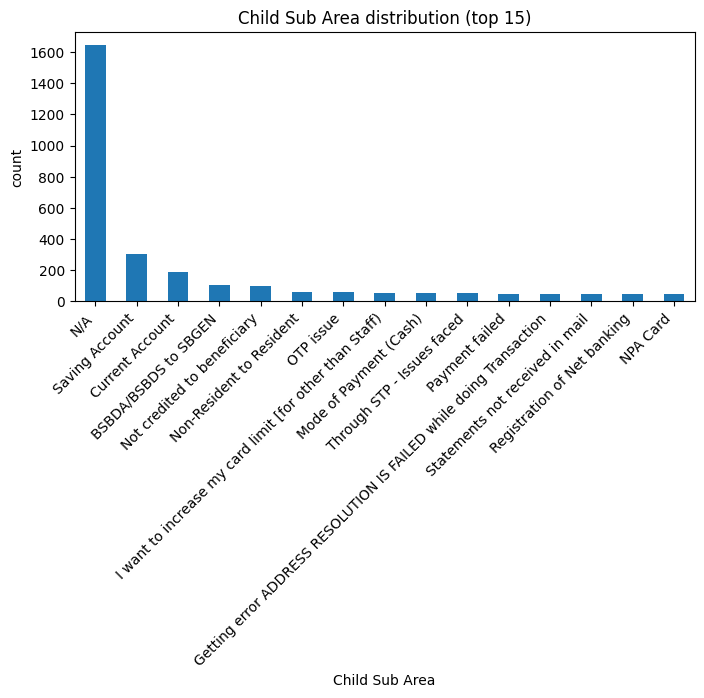

### Pipeline diagrams

**Feature preprocessor**

ColumnTransformer(transformers=[('text',
                                 TfidfVectorizer(max_features=100000,
                                                 ngram_range=(1, 2)),
                                 'clean_body'),
                                ('category',
                                 OneHotEncoder(handle_unknown='ignore'),
                                 ['sender_domain'])])

**Model pipeline (xgb_pipelines['Type'])**

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('text',
                                                  TfidfVectorizer(max_features=100000,
                                                                  ngram_range=(1,
                                                                               2)),
                                                  'clean_body'),
                                                 ('category',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  ['sender_domain'])])),
                ('clf',
                 XGBClassifier(base_score=None, booster=None, callbacks=None,
                               colsample_bylevel=None, colsample_bynode=None,
                               colsample_bytree=0.8, devic...
                               feature_types=None, feature_weights=None,
                               gamma=None, grow_policy=None,
                               importance_type=None,
                               interaction_constraints=None, learning_rate=0.1,
                               max_bin=None, max_cat_threshold=None,
                               max_cat_to_onehot=None, max_delta_step=None,
                               max_depth=6, max_leaves=None,
                               min_child_weight=None, missing=nan,
                               monotone_constraints=None, multi_strategy=None,
                               n_estimators=300, n_jobs=-1, num_class=5, ...))])

### Confusion matrices

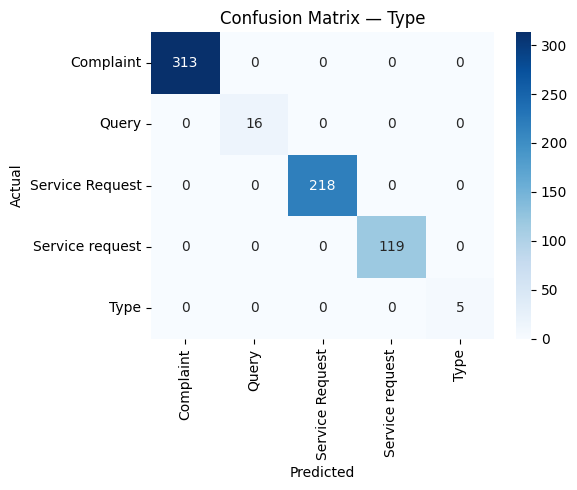

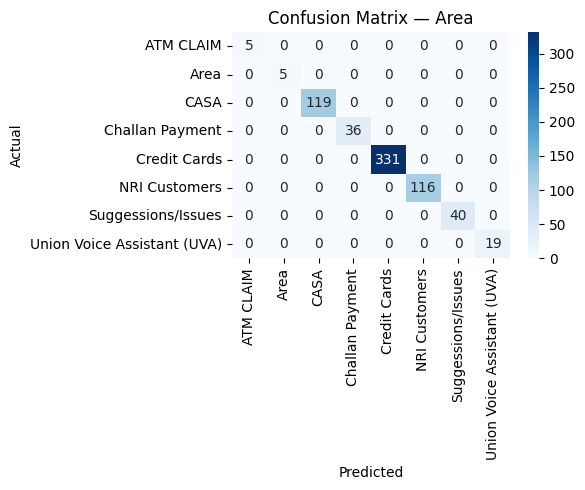

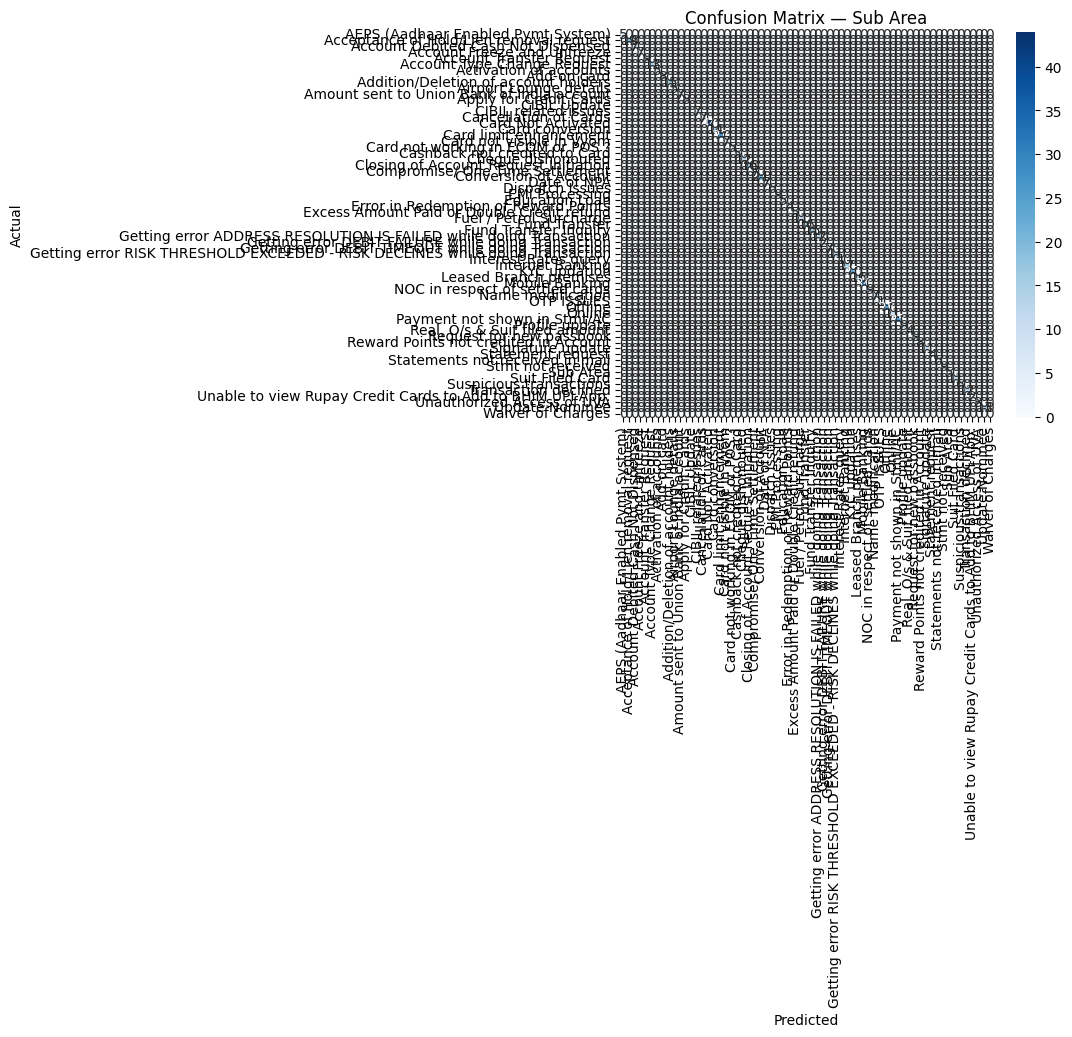

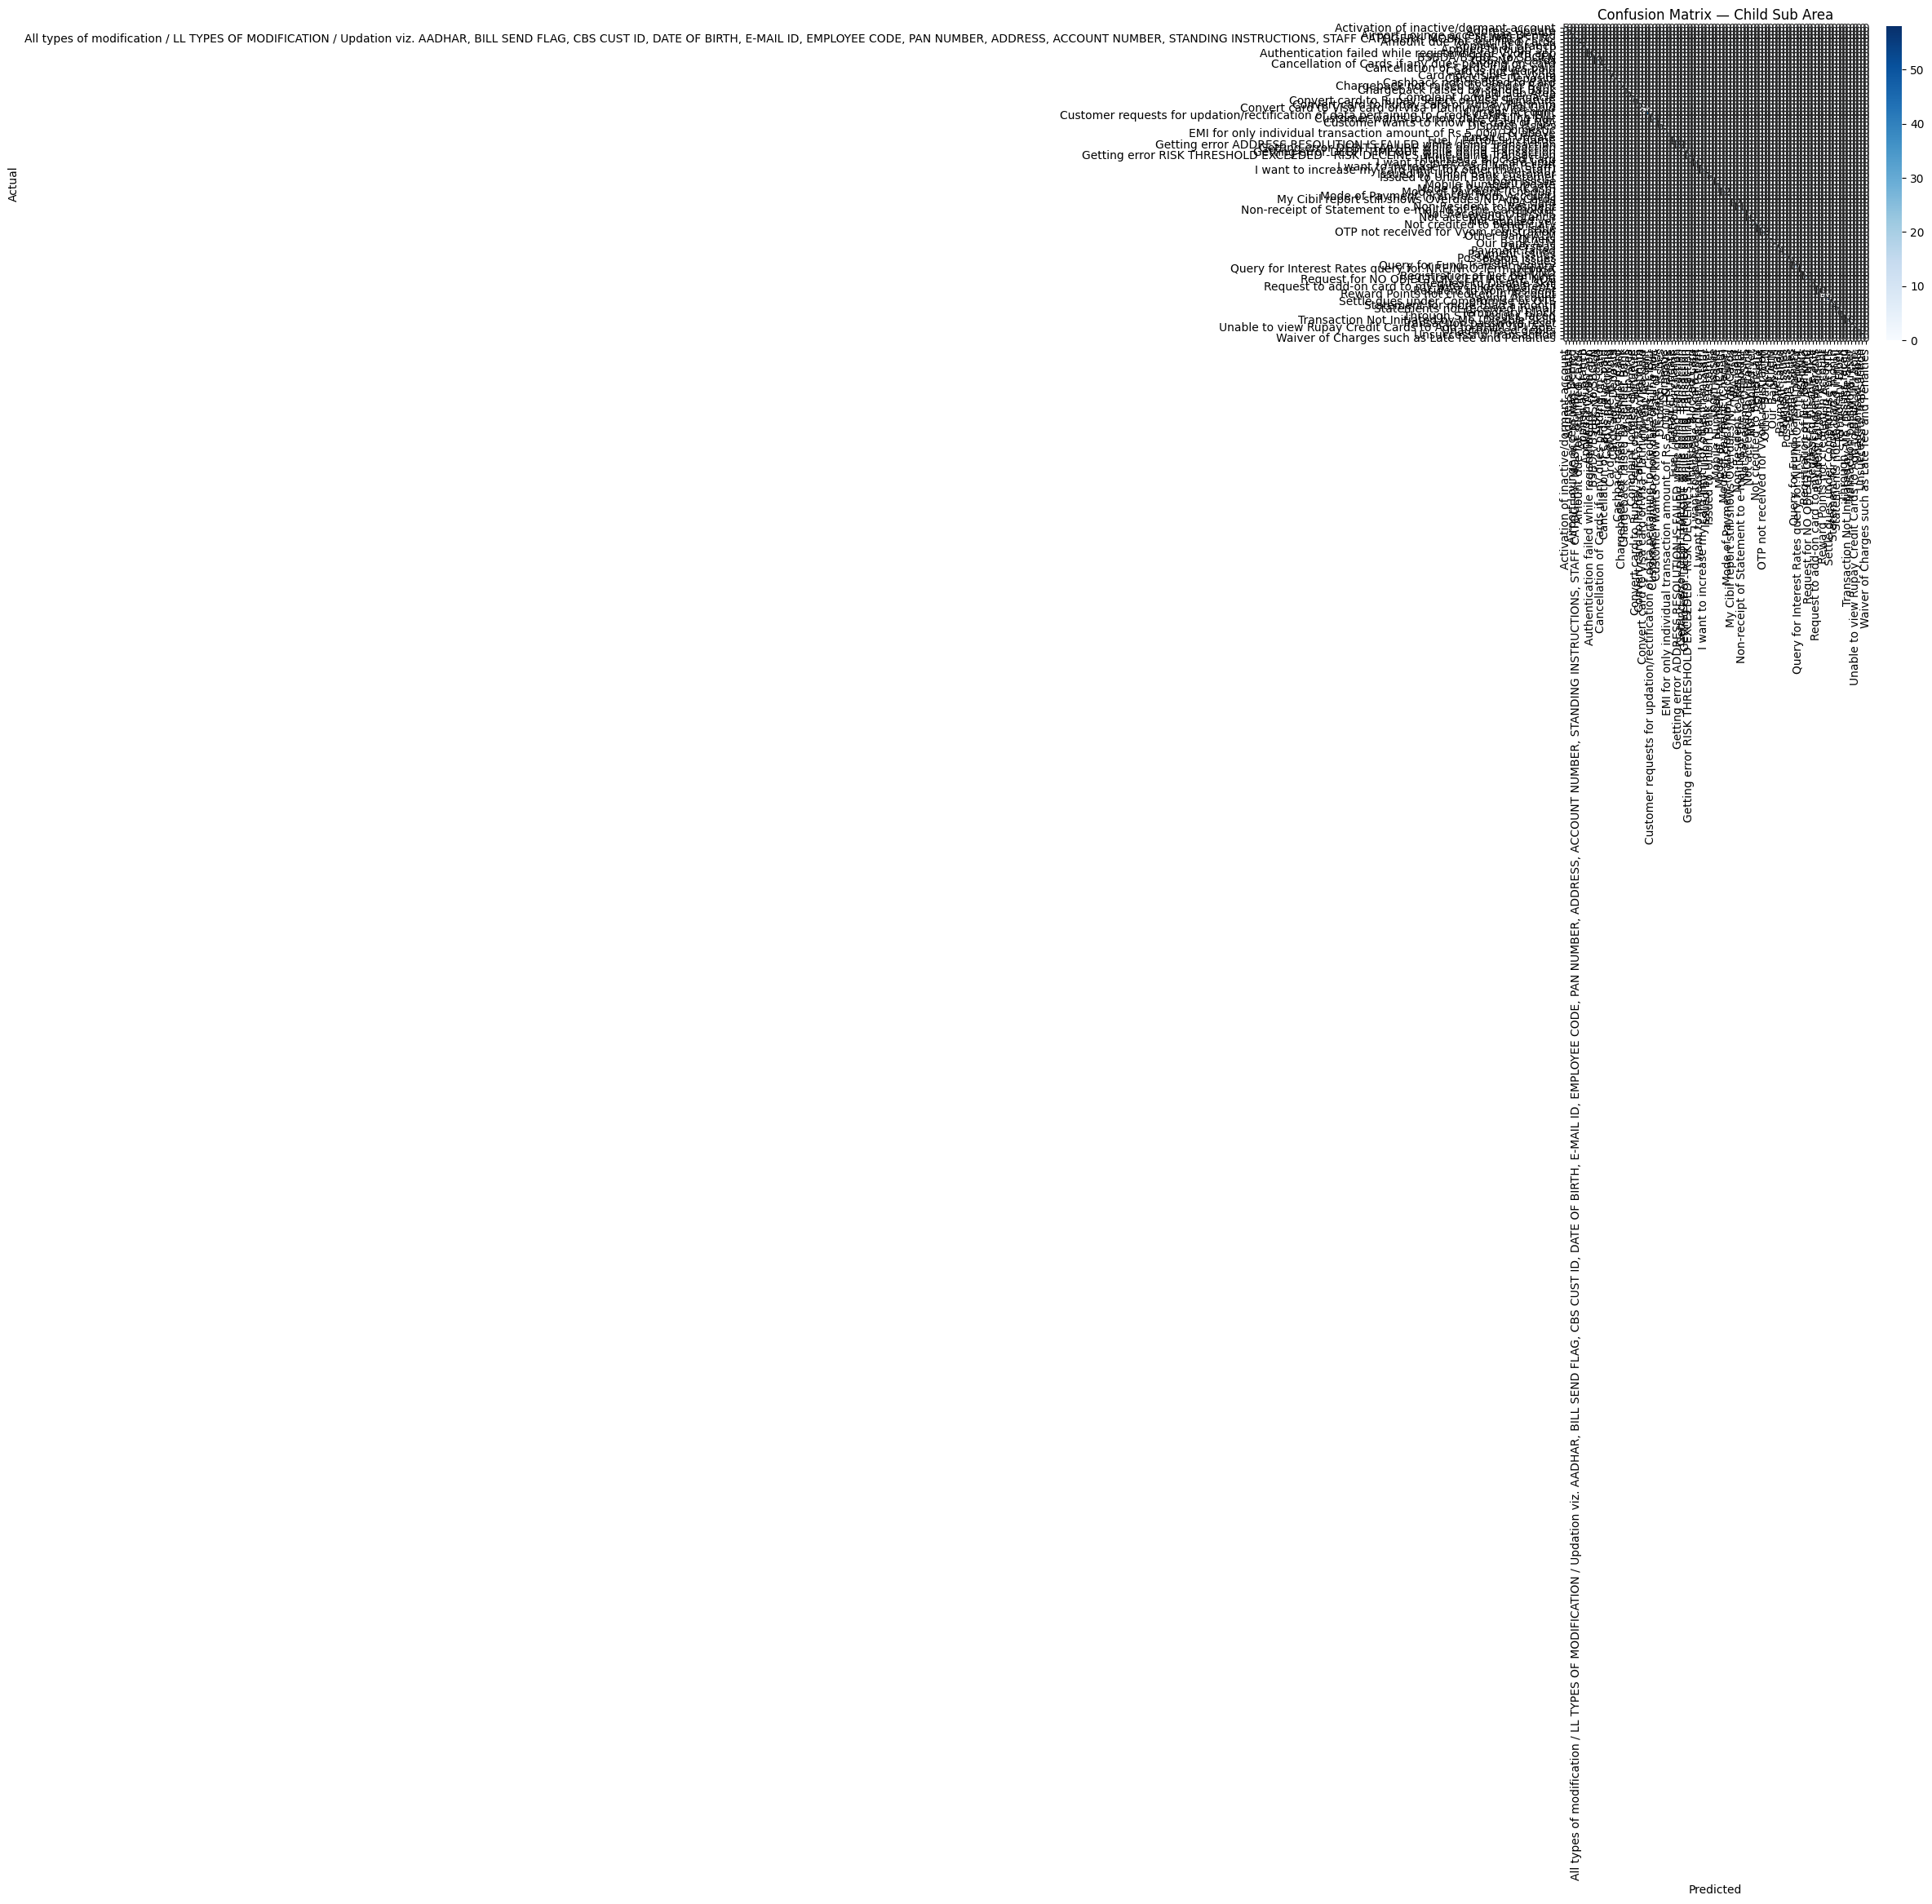

### SHAP summary (compact)

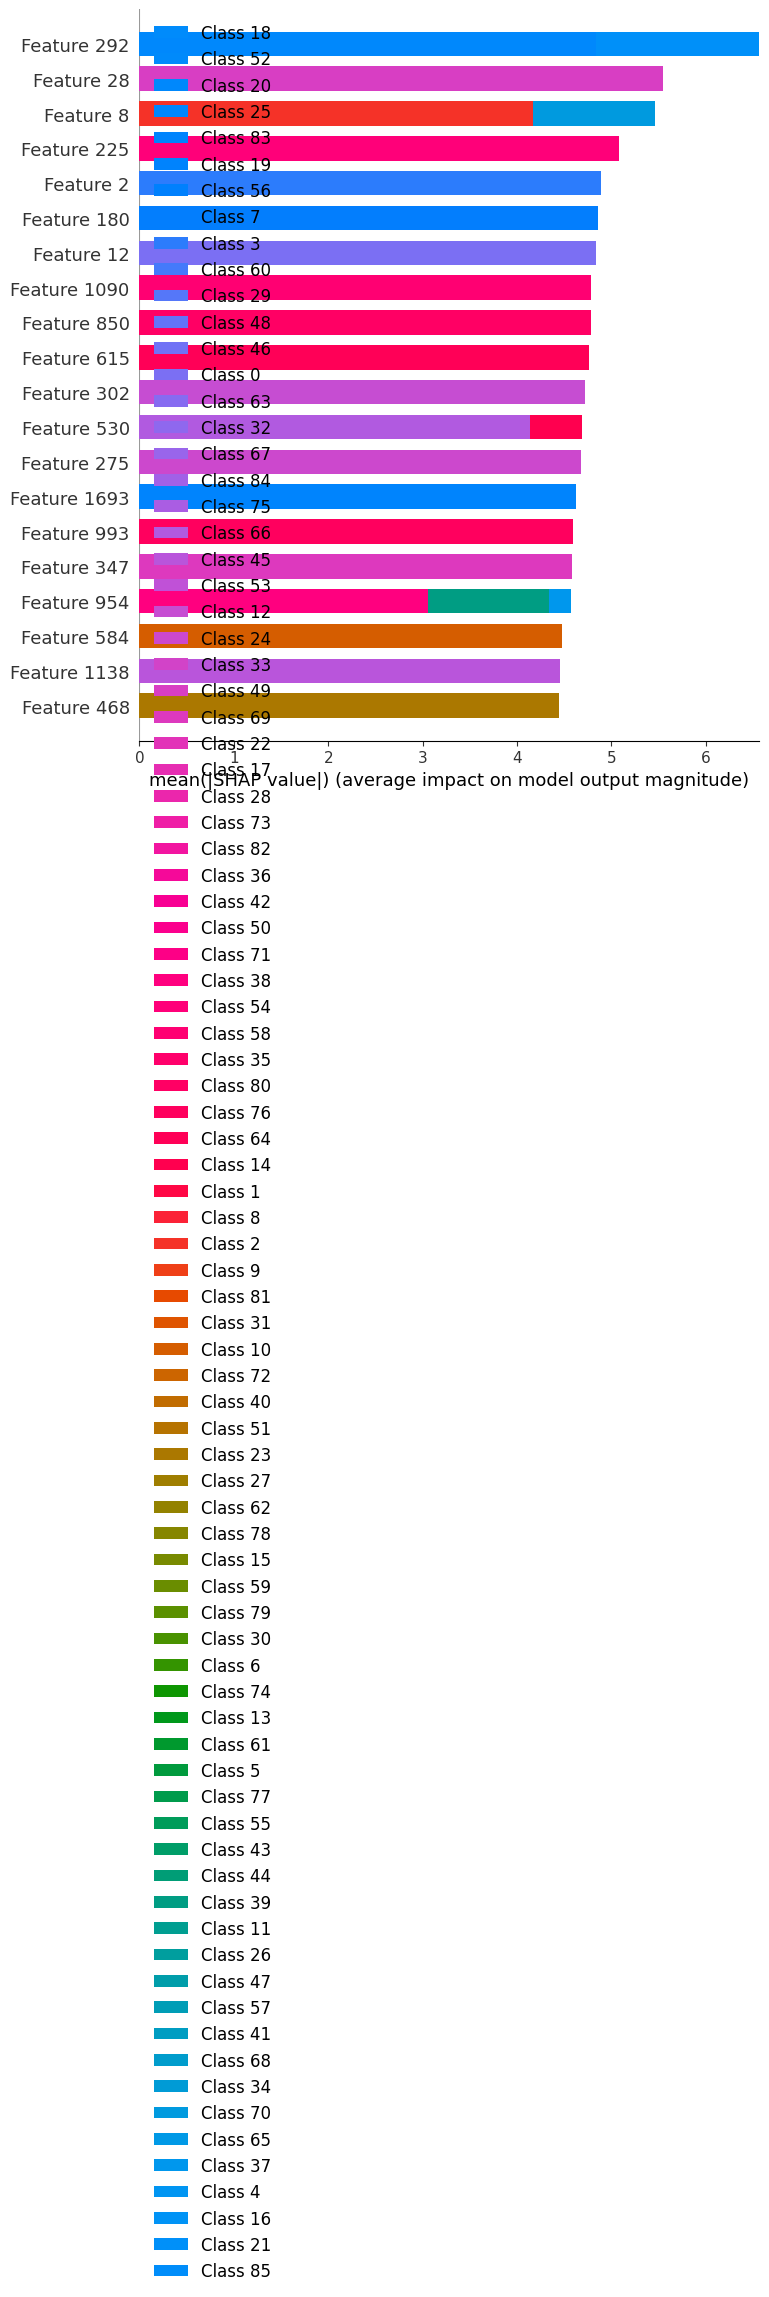

> ✅ Visual add-ons complete (no logic altered).

In [27]:
# === VISUALS ONLY — NO LOGIC CHANGES ===
# Lightweight charts/diagrams to improve readability of data-processing & model behavior.
# Safe to run at the end; each block checks for needed variables and skips gracefully if absent.

import warnings
warnings.filterwarnings("ignore")

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Optional: seaborn only for prettier confusion matrices. Will fallback if not available.
try:
    import seaborn as sns
    _HAS_SNS = True
except Exception:
    _HAS_SNS = False

# For pipeline diagrams
try:
    from sklearn import set_config
    _HAS_SK = True
except Exception:
    _HAS_SK = False

# For confusion matrices
try:
    from sklearn.metrics import confusion_matrix
    _HAS_CM = True
except Exception:
    _HAS_CM = False

# For SHAP (optional readability tweak)
try:
    import shap
    _HAS_SHAP = True
except Exception:
    _HAS_SHAP = False

from IPython.display import display, Markdown

def _print_section(title):
    display(Markdown(f"### {title}"))

# -------------------------------
# 1) DATA PEEKS (lengths & class balance)
# -------------------------------
if 'df' in globals() and isinstance(df, pd.DataFrame):
    _print_section("Quick data peeks")

# Email body length vs token count (uses clean_body if available, else email_body)
    try:
        fig, axes = plt.subplots(1, 2, figsize=(12, 4))

# Character length of raw email body
        (df['email_body']
            .astype(str)
            .str.len()
            .clip(0, 2000)
            .hist(ax=axes[0], bins=40))
        axes[0].set_title('Email body length (chars)')
        axes[0].set_xlabel('chars'); axes[0].set_ylabel('count')

# Token count (prefer clean_body if defined)
        token_source_col = 'clean_body' if 'clean_body' in df.columns else 'email_body'
        (df[token_source_col]
            .astype(str)
            .str.split()
            .map(len)
            .clip(0, 500)
            .hist(ax=axes[1], bins=40))
        axes[1].set_title(f"Token count ({token_source_col})")
        axes[1].set_xlabel('tokens'); axes[1].set_ylabel('count')

        plt.tight_layout(); plt.show()
    except Exception as e:
        print(f"[Skip length/token histograms] Reason: {e}")

# Class balance per label column (uses TARGET_COLS if available; else common defaults)
    try:
        default_targets = ['Type', 'Area', 'Sub Area', 'Child Sub Area']
        if 'TARGET_COLS' in globals():
            label_cols = [c for c in TARGET_COLS if c in df.columns]
        else:
            label_cols = [c for c in default_targets if c in df.columns]

        for col in label_cols:
            _print_section(f"Distribution (top 15) — {col}")
            vc = df[col].fillna('N/A').value_counts().head(15)
            plt.figure(figsize=(8, 3.5))
            vc.plot(kind='bar')
            plt.title(f'{col} distribution (top 15)')
            plt.xlabel(col); plt.ylabel('count'); plt.xticks(rotation=45, ha='right')
            plt.tight_layout(); plt.show()
    except Exception as e:
        print(f"[Skip class-balance bars] Reason: {e}")
else:
    print("[Info] Skipping data peeks: 'df' dataframe not found.")

# -------------------------------
# 2) PIPELINE DIAGRAMS
# -------------------------------
try:
    _print_section("Pipeline diagrams")
    if _HAS_SK:
        set_config(display='diagram')

# Show feature preprocessor diagram if available
    if 'preprocessor' in globals():
        display(Markdown("**Feature preprocessor**"))
        display(preprocessor)
    else:
        print("[Info] 'preprocessor' not found; skipping preprocessor diagram.")

# Show one full model pipeline (prefers XGB, else RF, else any dict named '*pipelines*')
    shown = False
    preferred_order = ['xgb_pipelines', 'rf_pipelines', 'best_pipelines', 'pipelines']
    for pname in preferred_order:
        if pname in globals():
            pipelines_dict = globals()[pname]
# Pick a sensible target column to display
            if 'TARGET_COLS' in globals() and isinstance(TARGET_COLS, (list, tuple)) and len(TARGET_COLS) > 0:
                key = TARGET_COLS[0]
                if key in pipelines_dict:
                    display(Markdown(f"**Model pipeline ({pname}[{key!r}])**"))
                    display(pipelines_dict[key])
                    shown = True
                    break
# Fallback: show the first item
            try:
                first_key = next(iter(pipelines_dict))
                display(Markdown(f"**Model pipeline ({pname}[{first_key!r}])**"))
                display(pipelines_dict[first_key])
                shown = True
                break
            except Exception:
                pass
    if not shown:
        print("[Info] No model pipeline dict found; skipping model pipeline diagram.")
except Exception as e:
    print(f"[Skip pipeline diagrams] Reason: {e}")

# -------------------------------
# 3) CONFUSION MATRICES (per target)
# -------------------------------
def _plot_conf_mat_for_target(pipe, X_test_local, y_true_enc, label_encoder, title):
    if not _HAS_CM:
        print("[Info] sklearn.metrics.confusion_matrix not available; skipping.")
        return
    y_pred_enc = pipe.predict(X_test_local)
# Build consistent label index
    labels = np.arange(len(label_encoder.classes_))
    cm = confusion_matrix(y_true_enc, y_pred_enc, labels=labels)
    plt.figure(figsize=(6, 5))
    if _HAS_SNS:
        sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                    xticklabels=label_encoder.classes_,
                    yticklabels=label_encoder.classes_)
    else:
        plt.imshow(cm, aspect='auto')
        plt.colorbar()
        plt.xticks(labels, label_encoder.classes_, rotation=45, ha='right')
        plt.yticks(labels, label_encoder.classes_)
# add simple annotations
        for (i, j), v in np.ndenumerate(cm):
            plt.text(j, i, str(v), ha='center', va='center')
    plt.title(title); plt.xlabel('Predicted'); plt.ylabel('Actual')
    plt.tight_layout(); plt.show()

try:
    _print_section("Confusion matrices")
# Determine available pipelines dict
    model_dict = None
    for pname in ['xgb_pipelines', 'rf_pipelines', 'best_pipelines', 'pipelines']:
        if pname in globals():
            model_dict = globals()[pname]
            break

# Need X_test, y_test_enc (dict) and label_encoders (dict)
    have_data = all(name in globals() for name in ['X_test', 'y_test_enc', 'label_encoders'])
    if model_dict is not None and have_data:
# Choose target columns
        if 'TARGET_COLS' in globals():
            cols = [c for c in TARGET_COLS if c in y_test_enc]
        else:
# Fallback guess
            cols = [c for c in ['Type', 'Area', 'Sub Area', 'Child Sub Area'] if c in y_test_enc]

        if len(cols) == 0:
            print("[Info] No matching target columns found in y_test_enc; skipping confusion matrices.")
        else:
            for col in cols:
                if col not in model_dict:
                    print(f"[Info] Model for target '{col}' not found; skipping.")
                    continue
                if col not in label_encoders:
                    print(f"[Info] LabelEncoder for target '{col}' not found; skipping.")
                    continue
                _plot_conf_mat_for_target(
                    model_dict[col], X_test, y_test_enc[col], label_encoders[col],
                    f"Confusion Matrix — {col}"
                )
    else:
        if model_dict is None:
            print("[Info] No pipelines dict found; skipping confusion matrices.")
        if not have_data:
            print("[Info] Missing X_test / y_test_enc / label_encoders; skipping confusion matrices.")
except Exception as e:
    print(f"[Skip confusion matrices] Reason: {e}")

# -------------------------------
# 4) SHAP SUMMARY (readability tweak)
# -------------------------------
try:
    _print_section("SHAP summary (compact)")
# Reuse precomputed SHAP objects if they exist
# Common variable names used earlier: 'shap_values', 'X_train_transformed', 'feature_names'
    if _HAS_SHAP and 'shap_values' in globals():
# Try to determine feature names & matrix
        features_matrix = None
        feature_names = None

        if 'X_train_transformed' in globals():
            features_matrix = X_train_transformed
        elif 'Xtr_dense' in globals():
            features_matrix = Xtr_dense  # sometimes used after .toarray()
        elif 'X_train' in globals() and 'preprocessor' in globals():
# last-resort transform (read-only; does not affect models)
            try:
                features_matrix = preprocessor.transform(X_train)
            except Exception:
                pass

        if 'feature_names' in globals():
            feature_names = feature_names
        elif 'preprocessor' in globals():
            try:
                feature_names = preprocessor.get_feature_names_out()
            except Exception:
                pass

        if features_matrix is not None:
            try:
# Compact bar plot (max_display=20)
                shap.summary_plot(
                    shap_values,
                    features=features_matrix,
                    feature_names=feature_names,
                    plot_type="bar",
                    max_display=20,
                    show=True
                )
            except Exception as e:
                print(f"[Info] Could not render SHAP summary bar: {e}")
        else:
            print("[Info] Feature matrix for SHAP not available; skipping SHAP summary.")
    else:
        print("[Info] SHAP objects not found; skipping SHAP summary.")
except Exception as e:
    print(f"[Skip SHAP visuals] Reason: {e}")

display(Markdown("> ✅ Visual add-ons complete (no logic altered)."))
